In [17]:
#!pip install catboost
#!pip install optuna
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1

In [14]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import metrics
import matplotlib.pyplot as plt
import catboost as cb
from catboost import CatBoostRegressor
from scipy.stats import skew
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score, r2_score, f1_score,\
roc_auc_score,mean_absolute_error,mean_absolute_percentage_error,max_error


In [3]:
data_fin_imprt=pd.read_csv("final.csv",  delimiter=',')



In [4]:
data_fin_imprt.head(15)

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,3.044522,4.955827,10.366309,6,1.791759,7.581210,1960,4.727388,6.461468,0.000000,...,False,False,False,True,False,False,False,False,True,False
1,3.044522,4.394449,9.360741,5,1.945910,7.581720,1961,0.000000,6.150603,4.976734,...,False,False,False,True,False,False,False,False,True,False
2,3.044522,4.406719,9.565775,6,1.945910,7.580189,1958,4.691348,6.828712,0.000000,...,False,False,False,True,False,False,False,False,True,False
3,3.044522,4.543295,9.320181,7,1.791759,7.585281,1968,0.000000,6.971669,0.000000,...,False,False,False,True,False,False,False,False,True,False
4,4.110874,4.317488,9.534668,5,1.791759,7.599902,1998,0.000000,6.674561,0.000000,...,False,False,False,True,False,False,False,False,True,False
5,4.110874,4.369448,9.208238,6,1.945910,7.600402,1998,3.044522,6.401917,0.000000,...,False,False,False,True,False,False,False,False,True,False
6,4.795791,3.737670,8.501267,8,1.791759,7.601902,2001,0.000000,6.424869,0.000000,...,False,False,False,True,False,False,False,False,True,False
7,4.795791,3.784190,8.518392,8,1.791759,7.597396,1992,0.000000,5.575949,0.000000,...,False,False,False,True,False,False,False,False,True,False
8,4.795791,3.688879,8.592301,8,1.791759,7.598900,1996,0.000000,7.074117,0.000000,...,False,False,False,True,False,False,False,False,True,False
9,4.110874,4.110874,8.922792,7,1.791759,7.600902,1999,0.000000,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False


In [5]:

x=data_fin_imprt.drop('SalePrice',axis=1)
y=data_fin_imprt['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [6]:
cb_mod = cb.CatBoostRegressor()
cb_mod.fit(x_train, y_train)
cb_pred = cb_mod.predict(x_test)

Learning rate set to 0.046842
0:	learn: 0.3888234	total: 65.9ms	remaining: 1m 5s
1:	learn: 0.3766847	total: 80.2ms	remaining: 40s
2:	learn: 0.3656902	total: 97ms	remaining: 32.2s
3:	learn: 0.3547144	total: 106ms	remaining: 26.3s
4:	learn: 0.3448709	total: 115ms	remaining: 22.9s
5:	learn: 0.3349048	total: 124ms	remaining: 20.5s
6:	learn: 0.3254512	total: 132ms	remaining: 18.7s
7:	learn: 0.3164950	total: 145ms	remaining: 18s
8:	learn: 0.3079398	total: 161ms	remaining: 17.7s
9:	learn: 0.2998627	total: 176ms	remaining: 17.4s
10:	learn: 0.2922187	total: 190ms	remaining: 17.1s
11:	learn: 0.2847889	total: 208ms	remaining: 17.1s
12:	learn: 0.2782969	total: 222ms	remaining: 16.8s
13:	learn: 0.2716830	total: 237ms	remaining: 16.7s
14:	learn: 0.2655972	total: 250ms	remaining: 16.4s
15:	learn: 0.2588504	total: 258ms	remaining: 15.9s
16:	learn: 0.2530364	total: 266ms	remaining: 15.4s
17:	learn: 0.2470125	total: 278ms	remaining: 15.2s
18:	learn: 0.2417173	total: 285ms	remaining: 14.7s
19:	learn: 0.2

In [7]:
cb_mod_sc=cb_mod.score(x_train,y_train)
print('CB Regression Model Score  : ',round(cb_mod_sc,3))
r2=r2_score(y_test,cb_pred)# computing and displaying the R.Sq of the model
print('R Sq. Value : ',round(r2,2))
rfr_adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-x.shape[1]-1)
print('Adjusted R Sq. Value is : ', round(rfr_adj_r2,3))
mean_sq=mean_squared_error(y_test,cb_pred)# computing and displaying the Mean square error of the model
print('Mean Square Error is : ', round(mean_sq,3))
lin_mse=mean_squared_error(y_test,cb_pred)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Square Error is : ', round(lin_rmse,3))
lin_mae=mean_absolute_error(y_test, cb_pred)
print('Mean Absoulue Error is : ', round(lin_mae,3))
scores_cvs = cross_val_score(cb_mod, x, y,scoring='r2' ,cv=5)
print("Accuracy :",round(scores_cvs.mean()*100,2),"%") # Accuracy of model

Streaming output truncated to the last 5000 lines.
5:	learn: 0.3359523	total: 38.5ms	remaining: 6.38s
6:	learn: 0.3264104	total: 44.7ms	remaining: 6.34s
7:	learn: 0.3178495	total: 51.6ms	remaining: 6.4s
8:	learn: 0.3091713	total: 57.8ms	remaining: 6.37s
9:	learn: 0.3008216	total: 64.1ms	remaining: 6.35s
10:	learn: 0.2927136	total: 70.3ms	remaining: 6.32s
11:	learn: 0.2862069	total: 76.6ms	remaining: 6.31s
12:	learn: 0.2786992	total: 82.9ms	remaining: 6.29s
13:	learn: 0.2715907	total: 89ms	remaining: 6.27s
14:	learn: 0.2648545	total: 95.2ms	remaining: 6.25s
15:	learn: 0.2585957	total: 101ms	remaining: 6.24s
16:	learn: 0.2523514	total: 107ms	remaining: 6.21s
17:	learn: 0.2467432	total: 114ms	remaining: 6.19s
18:	learn: 0.2410957	total: 120ms	remaining: 6.18s
19:	learn: 0.2356918	total: 129ms	remaining: 6.31s
20:	learn: 0.2305310	total: 135ms	remaining: 6.28s
21:	learn: 0.2260610	total: 144ms	remaining: 6.39s
22:	learn: 0.2210549	total: 150ms	remaining: 6.37s
23:	learn: 0.2168033	total: 1

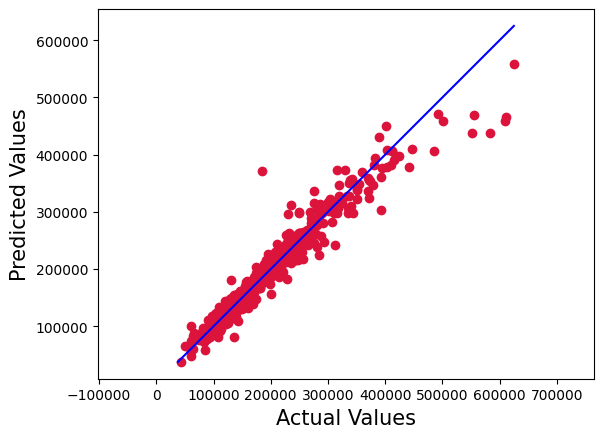

In [9]:
Actual_Price=np.expm1(y_test)
Predicted_Price=np.expm1(cb_pred)
plt.scatter(Actual_Price, Predicted_Price, c='crimson')
p1 = max(max(Predicted_Price), max(Actual_Price))
p2 = min(min(Predicted_Price), min(Actual_Price))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

<ipython-input-11-9e03f58b62ce>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot((y_test-cb_pred),bins=100);


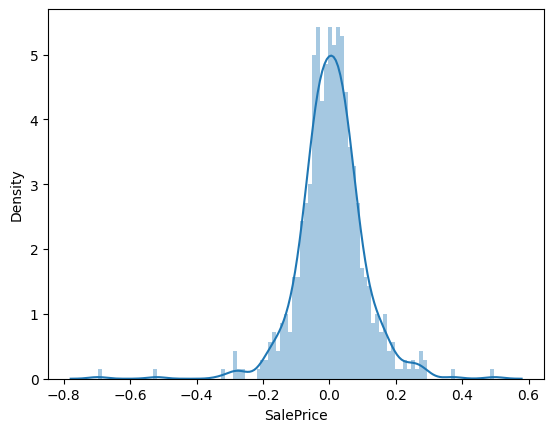

In [11]:
sb.distplot((y_test-cb_pred),bins=100);

In [19]:
# catboost optuna hyperparameter tuning
def objective(trial):
    # Define hyperparameter search space
    param = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.05, 1.0),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    # Train model
    model = cb.CatBoostRegressor(**param)
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)],  verbose=False)

    # Predict and evaluate
    predict = model.predict(x_test)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    return rmse  # Minimize RMSE

# Run Optuna optimization
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
# Print best hyperparameters
print("Best RMSE:", study.best_value)
print("Best Hyperparameters:", study.best_params)


[I 2025-03-03 18:48:26,358] A new study created in memory with name: no-name-5f44041d-a476-4aa8-89ad-8341f7181cf3
<ipython-input-19-ed404377447c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.05, 1.0),
<ipython-input-19-ed404377447c>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.05, 1.0),
[I 2025-03-03 18:48:27,750] Trial 0 finished with value: 0.1150153869560835 and parameters: {'iterations': 393, 'learning_rate': 0.018970395703739533, 'depth': 5, 'subsample': 0.7626490329056139, 'colsample_bylevel': 0.48559080740987143, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.115015386

Number of finished trials: 50
Best trial:
Best RMSE: 0.09703170289102872
Best Hyperparameters: {'iterations': 327, 'learning_rate': 0.08553430215534374, 'depth': 6, 'subsample': 0.3638350977064947, 'colsample_bylevel': 0.998004550960387, 'min_data_in_leaf': 81}


In [20]:
cb_mod = cb.CatBoostRegressor(iterations= 327, learning_rate= 0.08553430215534374, depth= 6, subsample= 0.3638350977064947, colsample_bylevel = 0.998004550960387,
                              min_data_in_leaf = 81)
cb_mod.fit(x_train, y_train)
cb_pred = cb_mod.predict(x_test)

0:	learn: 0.3788062	total: 6.65ms	remaining: 2.17s
1:	learn: 0.3581030	total: 13.5ms	remaining: 2.19s
2:	learn: 0.3405529	total: 19.6ms	remaining: 2.11s
3:	learn: 0.3229163	total: 25.5ms	remaining: 2.06s
4:	learn: 0.3071207	total: 31.4ms	remaining: 2.02s
5:	learn: 0.2917703	total: 37.2ms	remaining: 1.99s
6:	learn: 0.2790643	total: 46.4ms	remaining: 2.12s
7:	learn: 0.2663453	total: 52.6ms	remaining: 2.1s
8:	learn: 0.2552990	total: 58.9ms	remaining: 2.08s
9:	learn: 0.2455227	total: 65ms	remaining: 2.06s
10:	learn: 0.2351327	total: 70.8ms	remaining: 2.03s
11:	learn: 0.2259251	total: 76.4ms	remaining: 2s
12:	learn: 0.2186026	total: 82.2ms	remaining: 1.99s
13:	learn: 0.2117295	total: 88.3ms	remaining: 1.97s
14:	learn: 0.2052848	total: 94.4ms	remaining: 1.96s
15:	learn: 0.1983747	total: 100ms	remaining: 1.95s
16:	learn: 0.1922540	total: 106ms	remaining: 1.93s
17:	learn: 0.1876721	total: 112ms	remaining: 1.92s
18:	learn: 0.1828878	total: 118ms	remaining: 1.91s
19:	learn: 0.1779141	total: 124m

In [22]:
cb_mod_sc=cb_mod.score(x_train,y_train)
print('CB Regression Model Score  : ',round(cb_mod_sc,3))
r2=r2_score(y_test,cb_pred)# computing and displaying the R.Sq of the model
print('R Sq. Value : ',round(r2,2))
rfr_adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-x.shape[1]-1)
print('Adjusted R Sq. Value is : ', round(rfr_adj_r2,3))
mean_sq=mean_squared_error(y_test,cb_pred)# computing and displaying the Mean square error of the model
print('Mean Square Error is : ', round(mean_sq,3))
lin_rmse=mean_squared_error(y_test,cb_pred)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Square Error is : ', round(lin_rmse,3))
lin_mae=mean_absolute_error(y_test, cb_pred)
print('Mean Absoulue Error is : ', round(lin_mae,3))
scores_cvs = cross_val_score(cb_mod, x, y,scoring='r2' ,cv=5)
print("Accuracy :",round(scores_cvs.mean()*100,2),"%")
# Accuracy of moadel based on parameter supplied by optuna

CB Regression Model Score  :  0.973
R Sq. Value :  0.95
Adjusted R Sq. Value is :  0.944
Mean Square Error is :  0.009
Root Mean Square Error is :  0.098
Mean Absoulue Error is :  0.069
0:	learn: 0.3805392	total: 6.72ms	remaining: 2.19s
1:	learn: 0.3599357	total: 14.4ms	remaining: 2.35s
2:	learn: 0.3401312	total: 20.8ms	remaining: 2.24s
3:	learn: 0.3217507	total: 27.2ms	remaining: 2.2s
4:	learn: 0.3044515	total: 33.4ms	remaining: 2.15s
5:	learn: 0.2906078	total: 39.8ms	remaining: 2.13s
6:	learn: 0.2766716	total: 45.9ms	remaining: 2.1s
7:	learn: 0.2655014	total: 52.1ms	remaining: 2.08s
8:	learn: 0.2529047	total: 58ms	remaining: 2.05s
9:	learn: 0.2424226	total: 64.2ms	remaining: 2.04s
10:	learn: 0.2326993	total: 70.2ms	remaining: 2.02s
11:	learn: 0.2242041	total: 76.3ms	remaining: 2s
12:	learn: 0.2158394	total: 82.6ms	remaining: 2s
13:	learn: 0.2081861	total: 88.6ms	remaining: 1.98s
14:	learn: 0.2008991	total: 94.6ms	remaining: 1.97s
15:	learn: 0.1943927	total: 101ms	remaining: 1.96s
16:

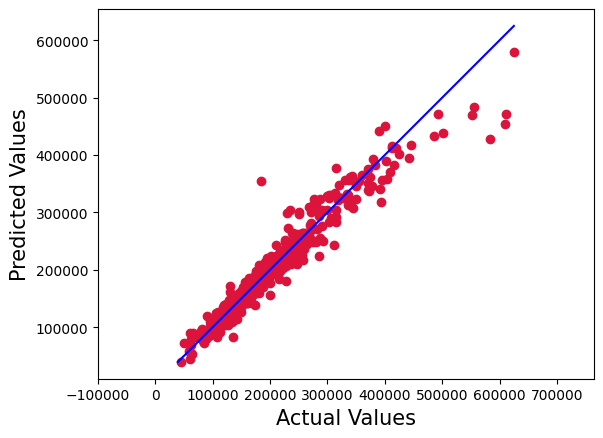

In [23]:
Actual_Price=np.expm1(y_test)
Predicted_Price=np.expm1(cb_pred)
plt.scatter(Actual_Price, Predicted_Price, c='crimson')
p1 = max(max(Predicted_Price), max(Actual_Price))
p2 = min(min(Predicted_Price), min(Actual_Price))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

<ipython-input-24-9e03f58b62ce>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot((y_test-cb_pred),bins=100);


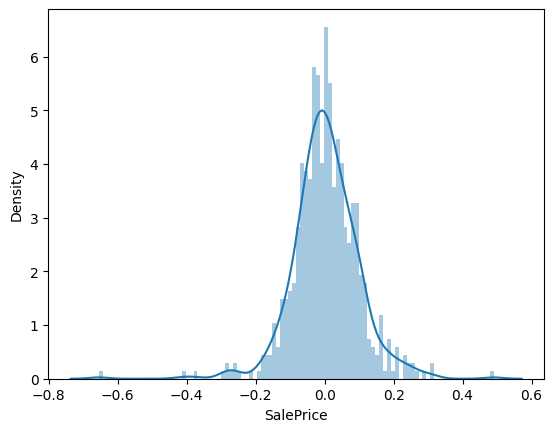

In [24]:
sb.distplot((y_test-cb_pred),bins=100);

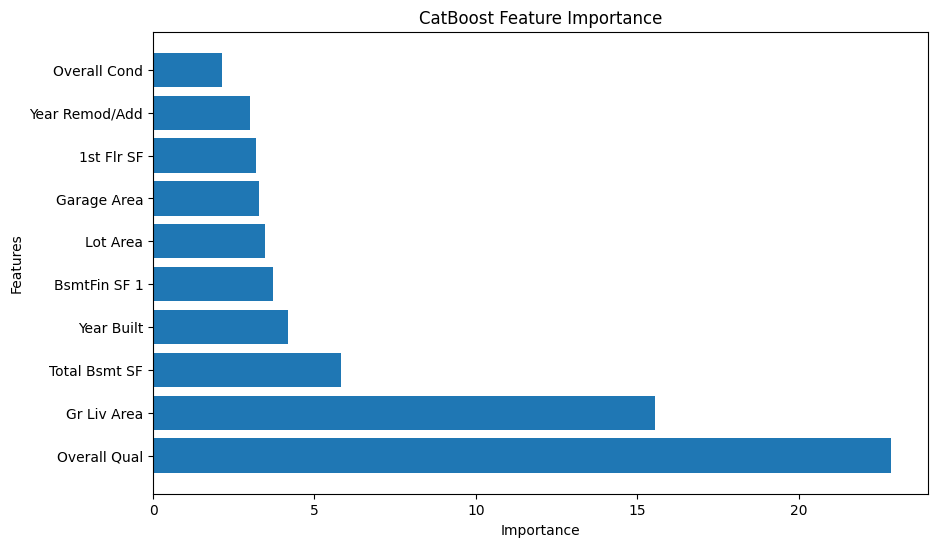

In [39]:
importances = cb_mod.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=x.columns).sort_values(ascending = False)[:10]
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [27]:
feature_important = cb_mod.get_feature_importance()


keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (10,15)) ## plot top 10 features

AttributeError: 'numpy.ndarray' object has no attribute 'keys'